<a href="https://colab.research.google.com/github/legalnlp21/legalnlp/blob/main/demo/Word2Vec/Word2Vec_TUTORIAL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Breve introdução teórica



## Motivação

A ideia principal dos métodos Word2Vec (W2V) é encontrar uma representação vetorial para palavras, tal representação elaborada a partir do contexto em que essas palavras aparecem. No caso deste pacote, os modelos são treinados com um corpo de texto extraído do meio jurídico.

A representação de palavras em espaços vetoriais torna possível a análise de proximidade semântica, correlação e outras comparações quantitativas entre palavras.

Os artigos originais sobre WordVec podem se encontrados em [[1]](https://arxiv.org/abs/1301.3781) e [[2]](https://papers.nips.cc/paper/2013/hash/9aa42b31882ec039965f3c4923ce901b-Abstract.html).

## A representação vetorial

A partir do corpo de texto (o conjunto de todos os textos usados para treinar o modelo) será coletado um conjunto com as $n$ palavras distintas, formando o "vocabulário". Com isso podemos ter uma representação vetorial na forma conhecida como "one-hot vector", que consiste em um vetor de tamanho $n$ preenchido inteiramente com zeros, exceto na posição utilizada para diferenciar cada palavra do vocabulário, com o número um nessa posição. Contudo esse tipo de representação não fornece informação sobre o sentido da palavra no contexto sendo o ponto principal em análise de sentimento, por outro lado a representação vetoial do Word2Vec nos fornece esse tipo de informação.

As representações vetoriais (as chamadas "*word embbedings*") geradas a partir do Word2Vec, podem ter uma dimensão arbitrária e carregam informações geradas a partir do contexto. O contexto é definido por um conjunto de palavras dentro de cada amostra, o tamanho desse conjunto é dado pela "janela", ou seja, o número de palavras ao redor da palavra principal.

Em suma, os modelos W2V podem ser gerados de duas formas: o método "*Skip-Gram*" e o método "*Continuous Bag of Words*" (CBOW). Os modelos gerados a partir do método *Skip-Gram* consistem de *embbedings* que representam o espaço paramétrico de uma Rede Neural, que recebe como *input* a palavra $w_t$, ou seja, na posição $t$, e tem como *output* prever as palavras $w_{t-d}$, ..., $w_{t-2}$, $w_{t-1}$ e $w_{t+1}$, $w_{t+2}$, ..., $w_{t+d}$, onde $d$ é o tamanho da janela. Já os modelos gerados a partir do método CBOW fazem o processo inverso, usando o contexto de palavras dentro da janela para prever a palavra alvo $w_t$.



## Aplicações imediatas

Sejam $v_1$ e $v_2$ vetores *one-hot vectors* é imediato que $<v_1, v_2> = 0$, ou seja, nesta representação, todos os vetores são ortogonais. Pouca informação pode se tirar disso, pois a reprsentação em *one-hot vector* não considera o contexto.

Operações vetoriais como a soma e subtração entre vetores em Word2Vec operam como "somas semânticas", por exemplo, uma equação como $(rei - homem) + mulher \approx rainha$ seria algo palpável, que dependeria do contexto que essas palavras são usadas no corpo de texto. 

Além disso, podemos agora ter uma visualização gráfica das palavras que leva em conta o contexto em que essas palavras geralmente são usadas no corpo de texto. Vamos dar um exemplo, utilizando *embbedings* de tamanho 100, e aplicando um PCA (*Principal Components Analysis*) para reduzir a dimensionalidade para 2, para visualizarmos as palavras em um gráfico bidimensional.

# Representando palavras utilizando Word2Vec

In [1]:
from IPython.display import clear_output

!pip install gensim==3.8.1
!pip install git+https://github.com/legalnlp21/legalnlp
clear_output()

Primeiro vamos chamar as bibliotecas necessárias. 

In [2]:
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from gensim.models import KeyedVectors
import pandas as pd
from legalnlp.get_premodel import get_premodel

Utilizando a função "get_premodel" disponível no pacote *LegalNLP* podemos fazer o download do modelo pré-treinado W2V.


In [3]:
# Downloading pre-trained model
get_premodel('wodc')

True

In [4]:
model = KeyedVectors.load("/content/W2V_D2V/w2v_d2v_dm_size_100_window_15_epochs_20")

Podemos ver a seguir, como o modelo consegue agrupar palavras semelhantes.

In [5]:
model.wv.most_similar('jurisprudencia')

[('jurisprudência_assente', 0.6141901016235352),
 ('iterativa_jurisprudência', 0.5145410895347595),
 ('jurisprudência_majoritária', 0.5138000249862671),
 ('jurisprudência', 0.5029575824737549),
 ('jurisprudência_pátria', 0.4976961016654968),
 ('notória_jurisprudência', 0.49725937843322754),
 ('jurisprudência_uníssona', 0.47410157322883606),
 ('dominante', 0.4658571481704712),
 ('vazada', 0.4633045792579651),
 ('jurisprudência_prevalecente', 0.45525240898132324)]

In [6]:
model.wv.most_similar('pandemia')

[('pandemia_mundial', 0.6916313767433167),
 ('pandemia_causada', 0.6867375373840332),
 ('epidemia', 0.6704655885696411),
 ('disseminação', 0.6358423233032227),
 ('pandemia_global', 0.5988448858261108),
 ('pandemia_provocada', 0.5955021381378174),
 ('quarentena', 0.595090389251709),
 ('surto', 0.588540256023407),
 ('crise', 0.5628268718719482),
 ('calamidade_pública', 0.541213870048523)]

Vamos definir uma função para vizualisar algumas clusters e verificar como elas se parecem geometricamente. Como a dimensão de cada embbeding é 100, teremos que utilizar um método de redução de dimensionalidade. Para isso, iremos utilizar o objeto PCA do SciKitLearn.

In [7]:
def pca_plot(model, p_c, pca, file = None):
    
    transforma = lambda palavra: pca.transform(palavra)
    
    plt.figure(figsize=(13, 8)) 
    wd_clusters = p_c.keys()


    for word in wd_clusters:
      labels = []
      tokens = []
      emb = model.wv[word]
      emb = (emb/np.sqrt(emb@emb)).tolist()
      tokens.append(emb)
      labels.append(word)
      
      k = 0
      for similar in model.wv.most_similar(word):
        k+=1
        emb = model.wv[similar[0]]
        emb = (emb/np.sqrt(emb@emb)).tolist()
        tokens.append(emb)
        labels.append(similar[0])
        if k == 5: break
        
        
      new_values = transforma(np.array(tokens))

      x = []
      y = []

      for value, i in zip(new_values, [k for k in range(0, len(labels))]):
        norma = 1#np.sqrt(value[0]**2 + value[1]**2)
        x.append(value[0]/norma)
        y.append(value[1]/norma)
            
      for i in range(len(x)):
          plt.scatter(x[i],y[i], c = p_c[word], s=50)
          plt.annotate(labels[i],
                      xy=(x[i], y[i]),
                      xytext=(5, 2),
                      fontsize = 10,
                      textcoords='offset points',
                      ha='right',
                      va='bottom')

    ln = []
    for i in range(len(p_c.items())):
      ln.append(mpatches.Patch(color= list(p_c.values())[i], label= list(p_c.keys())[i])) 

    plt.xlabel('PC1 ('+str(round(pca.explained_variance_ratio_[0]*100,2))+'%)', size=12)
    plt.ylabel('PC2 ('+str(round(pca.explained_variance_ratio_[1]*100,2))+'%)', size=12)
    plt.legend(handles=ln)
    if type(file) is not None:
      plt.savefig(file, dpi = 800)
    plt.show()

In [8]:
pca = PCA(n_components = 2)
emb_norm = model.wv.vectors/(np.sqrt(np.sum(model.wv.vectors**2, axis = 1))).reshape((-1,1))
pca.fit(emb_norm)

PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [9]:
pca.explained_variance_ratio_

array([0.04819773, 0.0352971 ])

Agora, basta chamarmos a função, vamos testar com o grupo de palavras nas chaves do dicionário "palavras", cada uma mapeando a sigla da cor utilizada no gráfico.

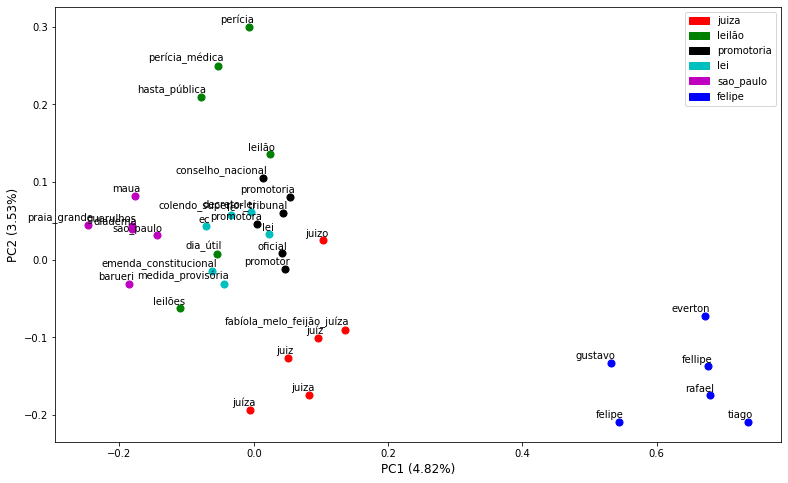

In [10]:
palavras = {'juiza':'r', 'leilão':'g', 'promotoria':'k', 'lei':'c', 'sao_paulo':'m', 'felipe':'b'}

pca_plot(model, p_c = palavras, pca = pca, file = "clusters_w2v")


Podemos ver que de fato, geometricamente, palavras mais próximas tem sentidos "mais próximos", encontramos *clusters* coerentes de *tokens* que se referem a nomes próprios, nomes de cidade e palavras com contextos relacionados entre si. Devemos lembrar que, após feita a redução de dimensionalidade, foi perdida uma alta porcentagem de explicação na variância nos dados, então alguns *clusters* que o usuário eventualmente venha a testar podem não ser tão coerentes em um espaço bidimensional. Contudo o efeito visual com apenas 8.35% de explicação já condiz com o que se esperava. 

# Aplicando o Word2Vec em um dataset para classificação

Nesse tutorial vamos demonstrar como utilizar *word-embeddings* geradas a partir do método Word2Vec, em cima de um corpo de texto, para classificação.

O método Word2Vec utiliza o contexto das palavras nos textos para gerar as *embbedings*. Para isso, foi utilizado o pacote *gensim* (versão 3.8.1), que integra as ferramentas necessárias para gerar, salvar e carregar as embbedings.

As ferramentas de limpeza de texto usadas foram criadas com o enfoque em textos do meio jurídico, mas podem ser usadas com outros textos igualmente. 

Para o funcionamento correto, recomendamos que o usuário tenha acesso aos seguintes módulos:
* ScikitLearn
* Keras
* Gensim
* String
* Numpy
* Pandas
* Ftfy

Neste tutorial, utilizamos um modelo de Redes Neurais Convolucionais para classificar processos legais em "Ativo", "Suspenso" e "Arquivado". O dataset esta disponível
[nesta página](https://www.kaggle.com/felipepolo/brazilian-legal-proceedings)
do Kaggle. \\
Este turorial foi baseados nos seguintes artigos 
[[3]](https://machinelearningmastery.com/develop-word-embedding-model-predicting-movie-review-sentiment/), [[4]](https://machinelearningmastery.com/best-practices-document-classification-deep-learning/) e [[5]](https://machinelearningmastery.com/use-word-embedding-layers-deep-learning-keras/)

In [11]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

De início, vamos importar as bibliotecas e funções que serão usadas adiante. Devemos também instalar as bibliotecas que não estão disponíveis por padrão no Google Colab.

In [38]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

from keras.preprocessing.text import one_hot
from keras.preprocessing.text import Tokenizer 
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers.embeddings import Embedding
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.callbacks import EarlyStopping

from string import punctuation

from tqdm import tqdm

from os import listdir

from numpy import array
from numpy import asarray
from numpy import zeros

from legalnlp.clean_functions import *

clear_output()

## Carregando os dados

Vamos carregar a base de dados, que esta em formato *csv*.

In [13]:
df=pd.read_csv('https://raw.githubusercontent.com/legalnlp21/legalnlp/main/demo/data_base.csv')
df.drop(columns=['Unnamed: 0'],inplace=True)
df.head()

,text,label
0,Início da Execução Juntado 0008003-11.2018.8.2...,H:Suspenso
1,Ofício Requisitório - Comunicação - Protocolo ...,H:Arquivado
2,Arquivado Provisoriamente aguardando manifestação,H:Suspenso
3,Petição Juntada Juntada a petição diversa - Ti...,H:Ativo
4,Remetidos os Autos para o Arquivo Geral – Devo...,H:Arquivado


In [14]:
df.shape

(6449, 2)

O dataset é composto por um conjunto de 6449 processos classificados nas 3 categorias:
* Ativo
* Suspenso
* Arquivado

Agora faremos a separação das categorias da nossa target, numerando de 0 a 2.

In [15]:
encoder = LabelEncoder()
encoder.fit(df['label'])
df['encoded'] = encoder.transform(df['label'])
df.drop(columns=['label'], inplace = True)
df

,text,encoded
0,Início da Execução Juntado 0008003-11.2018.8.2...,2
1,Ofício Requisitório - Comunicação - Protocolo ...,0
2,Arquivado Provisoriamente aguardando manifestação,2
3,Petição Juntada Juntada a petição diversa - Ti...,1
4,Remetidos os Autos para o Arquivo Geral – Devo...,0
...,...,...
6444,Remetidos os Autos para o Arquivo Geral – Devo...,2
6445,Certidão de Trânsito em Julgado com Baixa Expe...,0
6446,Petição Juntada Nº Protocolo: WSCB.19.70085805...,1
6447,Remetidos os Autos para o Tribunal de Justiça/...,1


In [16]:
X_textos = df['text'].apply(clean)
X_textos.head(5)

0    início da execução juntado [processo] - - cump...
1    ofício requisitório - - comunicação - - protoc...
2    arquivado provisoriamente aguardando manifestação
3    petição juntada juntada a petição diversa - - ...
4    remetidos os autos para o arquivo geral – devo...
Name: text, dtype: object

In [17]:
labels = np.array(df['encoded'])
labels[:5]

array([2, 0, 2, 1, 0])

Com isso feito, podemos tratar nossos dados para que a rede possa interpreta-los e trabalhar de forma adequada.

## Preparando os dados

O dataset que estamos usando não precisou de muito tratamento. Para as próprias aplicações, o leitor deve verificar com cautela as peculiaridades dos dados, antes de realizar a "tokenização".

Com nossos textos tratados, vamos começar a prepará-los para serem recebidos pela rede neural. A estrutura basica da rede neural para NLP (*Natural Language Processing*) deve iniciar com uma camada chamada de "embedding layer". Essa camada é a responsável por traduzir as palavras para vetores. Ela fara isso a partir de uma matriz de pesos, onde cada i-ésima linha contém o vetor referente a i-ésima palavra.

Portanto, devemos indexar cada *token* a um número natural, e representar nossos textos como vetores de indexação, ou seja, vetores com os números inteiros referentes a cada palavra. Para isso vamos tokenizar nosso corpo de texto utilizando o objeto *Tokenizer* do Keras. 

In [18]:
t = Tokenizer()
t.fit_on_texts(X_textos)
tamanho_vocab = len(t.word_index) + 1
encoded_textos = array(t.texts_to_sequences(X_textos))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  after removing the cwd from sys.path.


In [19]:
t.index_word[122], t.index_word[5], t.index_word[69], t.index_word[59], t.index_word[34], t.index_word[76], "..."

('início', 'da', 'execução', 'juntado', 'processo', 'cumprimento', '...')

In [20]:
print(encoded_textos[0])

[122, 5, 69, 59, 34, 76, 2, 56]


Cada vetor agora representa um texto, contúdo, cada um pode ter tamanhos distintos. Devemos padroniza-los, aplicando *zero-padding.*

In [21]:
len_maior = 0
for lista in encoded_textos:
  if len(lista) > len_maior: len_maior = len(lista)

len_maior

306

Vamos usar a função "pad_sequences" do Keras para ajustar o tamanho dos textos para 306. Além disso, é recomendável que passemos os índices para "float".

In [22]:
padded_docs = pad_sequences(encoded_textos, maxlen=len_maior, padding='post').astype('float32')

len(padded_docs[0])

306

Nossos textos estão prontos para serem recebidos pela rede neural, contudo, ainda é necessário gerar a camada de *embbeding* da rede. Faremos isso na próxima seção.

Também devemos tratar o nosso vetor de categorias. Por padrão, nossa target deve estar em formato matricial, com 1 na coluna representante da categoria do texto daquela linha e 0 nas demais.

Vamos usar o objeto "OneHotEncoder" do ScikitLearn e passar a matriz para a forma densa (objeto retorna na forma de matriz esparça). 

In [23]:
encoder = OneHotEncoder(handle_unknown='ignore')
label_onehot = encoder.fit_transform(labels.reshape((-1,1))).todense()

label_onehot[:3]

matrix([[0., 0., 1.],
        [1., 0., 0.],
        [0., 0., 1.]])

Agora, com nossos dados preparados, começaremos a cuidar da "embbeding layer". 

## Preparando as embeddings

Com o modelo carregado, já podemos estruturar a matriz de pesos. Neste caso específico, todas as palavras do corpo de texto dos dados estão contidas no vocabulário do modelo Word2Vec, contudo, o leitor deve ter o cuidado de tratar os casos em que essa equivalência não aconteça.

Vamos estruturar um dicionário, no qual cada chave é uma palavra do corpo do vocabulário do modelo e cada valor representa sua embbeding.

In [24]:
wv_dict = dict(zip(model.wv.index2word[:], model.wv.vectors[:]))

Para acelerar o treino da rede, e diminuir o tamanho da matriz de pesos, podemos fazer um dicionário somente com as palavras do *corpus*, pois geralmente, o vocabulário do modelo *pre-trained Word2Vec* é muito mais extenso que o necessário. 

In [25]:
wv_dict_updated = {}
for palavra in t.index_word.values():
  if palavra in wv_dict.keys():
    wv_dict_updated[palavra] = wv_dict[palavra]

Por fim, podemos estruturar a matriz de pesos, colocando a palavra de i-ésimo índice na i-ésima linha da matriz.

In [26]:
matriz_de_pesos = zeros((tamanho_vocab, 100))
for palavra, i in t.word_index.items():
  vetor_embed =  wv_dict_updated.get(palavra)
  if vetor_embed is not None:
    matriz_de_pesos[i] = vetor_embed

matriz_de_pesos.shape

(2827, 100)

## Treinando o modelo

Com nossos dados codificados, e nossa matriz de pesos pronta, podemos começar a estruturar nossa Rede Neural. Nosso modelo será uma Rede Neural Convolucional, ou seja, aplicaremos uma camada de filtragem e em seguida uma camada de *pooling*, buscando ressaltar informações importantes das *embbedings*. 

Nossa rede terá a seguinte estrutura:
1. A primeira camada de *embbeding*, que fara a codificação das palavras (representadas como índices) nos seus respectivos vetores.
2. A segunda será uma camada convolucional, com 128 filtros no output, *kernel* de tamanho 5 e função de ativação 'ReLU'.
3. A terceira camada será a *MaxPooling* de tamanho 2.
4. Como o output da 3ª camada é um tensor, a quarta camada será uma camada de "achatamento".
5. Por fim, a camada do output, de tamanho 3 e função de ativação *softmax*.

In [27]:
emb = Embedding(tamanho_vocab, 100, weights = [matriz_de_pesos], input_length=len_maior, trainable = False)

rede = Sequential()

rede.add(emb)
rede.add(Conv1D(filters=128, kernel_size=5, activation='relu'))
rede.add(MaxPooling1D(pool_size=2))
rede.add(Flatten())
rede.add(Dense(3, activation='softmax'))

Para terminar a estrutura da rede, vamos usar a função perda como 'categorical_crossentropy', o caso categórico da entropia cruzada, para o otimizador ultilizaremos o 'adam' e a métrica de avaliação será a acurácia. Podemos ver a arquitetura utilizando o método "*Sequential().summary()*".

In [28]:
rede.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
print(rede.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 306, 100)          282700    
_________________________________________________________________
conv1d (Conv1D)              (None, 302, 128)          64128     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 151, 128)          0         
_________________________________________________________________
flatten (Flatten)            (None, 19328)             0         
_________________________________________________________________
dense (Dense)                (None, 3)                 57987     
Total params: 404,815
Trainable params: 122,115
Non-trainable params: 282,700
_________________________________________________________________
None


Vamos separar nossos dados em dados de treino e teste.

In [29]:
X_treino, X_teste, y_treino, y_teste = train_test_split(padded_docs, label_onehot, random_state=42, train_size=0.7, test_size=0.3)

Por fim, podemos treinar o modelo e verificar nossos resultados. 

In [30]:
rede.fit(X_treino, y_treino, epochs=50, validation_split=0.1, batch_size=500, verbose=1,  callbacks=[EarlyStopping(monitor='val_loss', patience=15)])

Epoch 1/50
9/9 [==============================] - 10s 982ms/step - loss: 0.8934 - accuracy: 0.6876 - val_loss: 0.7344 - val_accuracy: 0.7876
Epoch 2/50
9/9 [==============================] - 9s 950ms/step - loss: 0.6230 - accuracy: 0.7836 - val_loss: 0.5904 - val_accuracy: 0.8053
Epoch 3/50
9/9 [==============================] - 9s 942ms/step - loss: 0.5285 - accuracy: 0.7986 - val_loss: 0.5332 - val_accuracy: 0.8319
Epoch 4/50
9/9 [==============================] - 9s 944ms/step - loss: 0.4612 - accuracy: 0.8161 - val_loss: 0.4813 - val_accuracy: 0.8230
Epoch 5/50
9/9 [==============================] - 9s 948ms/step - loss: 0.4313 - accuracy: 0.8215 - val_loss: 0.4640 - val_accuracy: 0.8540
Epoch 6/50
9/9 [==============================] - 9s 951ms/step - loss: 0.3925 - accuracy: 0.8535 - val_loss: 0.4463 - val_accuracy: 0.8606
Epoch 7/50
9/9 [==============================] - 9s 939ms/step - loss: 0.3612 - accuracy: 0.8717 - val_loss: 0.4282 - val_accuracy: 0.8628
Epoch 8/50
9/9 [===

In [31]:
loss, acc_treino = rede.evaluate(X_treino, y_treino, verbose=0)
loss2, acc_teste = rede.evaluate(X_teste, y_teste, verbose=0)
print(f'Acurácia no treino: {round(acc_treino*100, 2)}%')
print(f'Acurácia no teste: {round(acc_teste*100, 2)}%')

Acurácia no treino: 89.06%
Acurácia no teste: 84.86%


In [32]:
predict = rede.predict(X_teste)

In [33]:
predict1 = np.argmax(predict, axis=1)

y_teste1 = np.argmax(y_teste, axis=1)
np.array(y_teste1.reshape(1,-1))[0]

array([2, 1, 1, ..., 1, 0, 1])

In [34]:
print(classification_report(y_teste1, predict1, labels=[0,1,2]))

              precision    recall  f1-score   support

           0       0.91      0.80      0.85       923
           1       0.79      0.94      0.86       864
           2       0.92      0.61      0.73       148

    accuracy                           0.85      1935
   macro avg       0.87      0.78      0.81      1935
weighted avg       0.86      0.85      0.85      1935



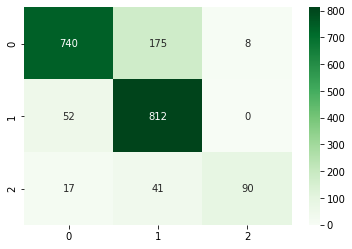

In [35]:
cm = confusion_matrix(y_teste1, predict1)
sns.heatmap(cm , fmt=".3g", annot= True, cmap="Greens")

plt.show()

Além dos métodos de predição usuais da Rede Neural do Keras, vamos usar o método de bootstrap para estimar o desvio padrão das nossas métricas usadas para medir o desempenho da Rede.

In [75]:
def bootstrap(X_test, y_test, model, nn=False, B=250):
    #Creating dictionary to store results
    out={}
    out['accuracy']=[]
    out['macro avg']={}
    out['macro avg']['f1-score']=[]
    out['macro avg']['recall']=[]
    out['macro avg']['precision']=[]
    out['weighted avg']={}
    out['weighted avg']['f1-score']=[]
    out['weighted avg']['recall']=[]
    out['weighted avg']['precision']=[]

    #Running Bootstrap on the test set
    for b in tqdm(range(B)):
        ind = np.random.choice(range(y_test.shape[0]),y_test.shape[0])
        X_test_boot, y_test_boot = X_test[ind,:], y_test[ind]

        y_pred=model.predict(X_test_boot)
        
        if nn:
            y_pred=np.argmax(y_pred,axis=1)
            report=classification_report(y_test_boot, y_pred, labels=[0, 1, 2], output_dict=True)
        else:
            report=classification_report(y_test_boot, y_pred, labels=[0, 1, 2], output_dict=True)

        out['accuracy'].append(report['accuracy'])
        out['macro avg']['f1-score'].append(report['macro avg']['f1-score'])
        out['macro avg']['recall'].append(report['macro avg']['recall'])
        out['macro avg']['precision'].append(report['macro avg']['precision'])
        out['weighted avg']['f1-score'].append(report['weighted avg']['f1-score'])
        out['weighted avg']['recall'].append(report['weighted avg']['recall'])
        out['weighted avg']['precision'].append(report['weighted avg']['precision'])

    #Preparing output
    y_pred=model.predict(X_test)
    
    if nn:
        y_pred=np.argmax(y_pred,axis=1)
        report=classification_report(y_test, y_pred, labels=[0, 1, 2], output_dict=True)
    else:
        report=classification_report(y_test, y_pred, labels=[0, 1, 2], output_dict=True)

    out['accuracy'] = [report['accuracy'], np.std(out['accuracy'])]
    out['macro avg']['f1-score'] = [report['macro avg']['f1-score'], np.std(out['macro avg']['f1-score'])] 
    out['macro avg']['recall'] = [report['macro avg']['recall'], np.std(out['macro avg']['recall'])] 
    out['macro avg']['precision'] = [report['macro avg']['precision'], np.std(out['macro avg']['precision'])] 
    out['weighted avg']['f1-score'] = [report['weighted avg']['f1-score'], np.std(out['weighted avg']['f1-score'])] 
    out['weighted avg']['recall'] = [report['weighted avg']['recall'], np.std(out['weighted avg']['recall'])] 
    out['weighted avg']['precision'] = [report['weighted avg']['precision'], np.std(out['weighted avg']['precision'])]
    
    return out

In [ ]:
def label_encoder(matriz):
  

  #Transforma a matriz de listas em uma lista com os indices
  indices = []
  for lista in range(matriz.shape[0]):
    for elemento in range(matriz.shape[1]):
      if matriz[lista, elemento] == 1:
         indices.append(elemento)

  return indices

y_teste_bootstrap = label_encoder(y_teste)

In [76]:
report_boot=bootstrap(np.array(X_teste), np.array(y_teste_bootstrap), rede, nn = True)

for i in ['accuracy', 'macro avg', 'weighted avg']:
 if i == 'accuracy':
     print("\n\n{:27}: {:.2f} ± {:.2f}".format(i, report_boot[i][0], report_boot[i][1]))
 for j in ['f1-score', 'recall', 'precision']:
   if i != 'accuracy':
     print("{:15}  {:10}: {:.2f} ± {:.2f}".format(i, j, report_boot[i][j][0], report_boot[i][j][1]))

100%|██████████| 250/250 [06:44<00:00,  1.62s/it]




accuracy                   : 0.85 ± 0.01
macro avg        f1-score  : 0.81 ± 0.01
macro avg        recall    : 0.78 ± 0.02
macro avg        precision : 0.87 ± 0.01
weighted avg     f1-score  : 0.85 ± 0.01
weighted avg     recall    : 0.85 ± 0.01
weighted avg     precision : 0.86 ± 0.01


Como tivemos uma boa acurácia no conjunto de validação, podemos dizer que nosso modelo teve uma boa performance no geral. 

Uma analise mais aprofundada nos dados e na arquitetura da rede poderia levar a performances ainda melhores. Essas análises no entanto fogem do escopo deste tutorial, contudo, encorajamos o leitor a elaborar modelos que performem ainda melhor, e a realizar uma análise e engenharia de dados ainda mais aprofundada. 

Esperamos ter ajudado. 

:D

#Referências

[1] Mikolov, T., Chen, K., Corrado, G., and Dean, J. (2013a).  Efficient estimation ofword representations in vector space.arXiv preprint arXiv:1301.3781. \\
[2] Mikolov,  T.,  Sutskever,  I.,  Chen,  K.,  Corrado,  G. S.,  and Dean,  J. (2013b).   Distributed representations of words and phrases and their compositionality.  In Advances in neural information processing systems, pages 3111–3119. \\
[3] Brownlee Jason(2017). https://machinelearningmastery.com/develop-word-embedding-model-predicting-movie-review-sentiment/ - acesso em: 04/08/2021.  \\
[4] Brownlee Jason(2017). https://machinelearningmastery.com/best-practices-document-classification-deep-learning/ - acesso em: 04/08/2021.  \\
[5] Brownlee Jason(2017). https://machinelearningmastery.com/use-word-embedding-layers-deep-learning-keras/ - acesso em: 04/08/2021. \\